In [1]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor, Pool
from scipy.stats import randint, uniform
import optuna
from optuna.samplers import TPESampler
import shap
import matplotlib.pyplot as plt
from importlib.metadata import version

print("Pandas version: " + str(pd.__version__))
print("Numpy version: " + str(np.__version__))
print("XGBoost version: " + str(xgb.__version__))
print("Scikit-learn version: " + str(version("scikit-learn")))
print("Catboost version: " + str(version("catboost")))
print("Scipy version: " + str(version("scipy")))
print("Optuna version: " + str(optuna.__version__))
print("Shap version: " + str(shap.__version__))
print("Matplotlib version: " + str(version("matplotlib")))

Pandas version: 2.3.3
Numpy version: 2.3.4
XGBoost version: 3.1.1
Scikit-learn version: 1.7.2
Catboost version: 1.2.8
Scipy version: 1.16.3
Optuna version: 4.6.0
Shap version: 0.49.1
Matplotlib version: 3.10.7


In [2]:
# load the target encoded data
with open('../data/temp/target_encoded_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']
encoder = data['encoder']
features = data['feature_names']
category_mappings = data['category_mappings']

print(f"Loaded: {data['encoding_method']}")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"Features: {features}")

Loaded: standard_target_encoding
X_train: (5769, 20)
X_val: (722, 20)
Features: ['health_service_area', 'hospital_county', 'permanent_facility_id', 'age_group', 'zip_code', 'gender', 'race', 'ethnicity', 'type_of_admission', 'patient_disposition', 'ccsr_procedure_description', 'apr_drg_description', 'apr_mdc_description', 'apr_severity_of_illness_description', 'apr_risk_of_mortality', 'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'emergency_department_indicator']


In [3]:
# fit an xgboost model
y_train_orig = np.exp(y_train)  # undo log transform
y_val_orig = np.exp(y_val)

xgb_model = xgb.XGBRegressor(
    n_estimators = 500,
    max_depth = 6,
    learning_rate = 0.1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    n_jobs = -1
)

# train
xgb_model.fit(X_train, y_train_orig)

# predict
y_val_pred = xgb_model.predict(X_val)

# evaluate
rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print(f"XGBoost on original scale LoS:")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

XGBoost on original scale LoS:
RMSE: 4.884, MAE: 2.653, R2: 0.379


In [4]:
# hyperparameter grid
xgb_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 42,
    n_jobs = -1
)

param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [4, 6, 8, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'gamma': [0, 0.1, 0.3, 0.5]
}

random_search = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions = param_grid,
    n_iter = 50,
    scoring = 'neg_mean_squared_error',
    cv = 10,
    verbose = 1,
    random_state = 42,
    n_jobs = -1
)

random_search.fit(X_train, y_train_orig)

# best parameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/Users/rob/Projects/GitHub/ml-engineering-zoomcamp/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}


In [5]:
# fit best model on training data
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train_orig)

y_val_pred = best_xgb.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print(f"XGBoost validation performance (original scale LoS):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

XGBoost validation performance (original scale LoS):
RMSE: 4.632, MAE: 2.326, R2: 0.441


Now try Catboost.

In [6]:
# catboost regression
y_train_orig = np.exp(y_train)  # undo log transform
y_val_orig = np.exp(y_val)

cat = CatBoostRegressor(
    iterations = 1500,
    learning_rate = 0.1,
    depth = 6,
    eval_metric = 'RMSE',
    random_seed = 42,
    verbose = 100
)

cat.fit(X_train, y_train_orig, eval_set = (X_val, y_val_orig), early_stopping_rounds = 50)

y_val_pred = cat.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print(f"CatBoost (depth: 6):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

0:	learn: 6.0207915	test: 6.0471906	best: 6.0471906 (0)	total: 59.5ms	remaining: 1m 29s
100:	learn: 3.5982020	test: 4.5001531	best: 4.4974421 (96)	total: 141ms	remaining: 1.96s
200:	learn: 3.1784168	test: 4.4613920	best: 4.4411080 (162)	total: 207ms	remaining: 1.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.441107952
bestIteration = 162

Shrink model to first 163 iterations.
CatBoost (depth: 6):
RMSE: 4.441, MAE: 2.323, R2: 0.487


In [7]:
# perform a random search
y_train_orig = np.exp(y_train)  # undo log transform
y_val_orig = np.exp(y_val)

# define parameter distributions
param_distributions = {
    'depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.2),
    'iterations': randint(500, 2000),
    'l2_leaf_reg': randint(1, 10),
    'min_data_in_leaf': randint(1, 50)
}

cat_base = CatBoostRegressor(
    eval_metric = 'RMSE',
    random_seed = 42,
    verbose = 0
)

random_search = RandomizedSearchCV(
    cat_base,
    param_distributions,
    n_iter = 20,  # number of parameter combinations to try
    cv = 3,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    verbose = 2,
    random_state = 42
)

random_search.fit(X_train, y_train_orig)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", -random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END depth=5, iterations=966, l2_leaf_reg=7, learning_rate=0.021616722433639893, min_data_in_leaf=24; total time=   1.5s
[CV] END depth=5, iterations=966, l2_leaf_reg=7, learning_rate=0.021616722433639893, min_data_in_leaf=24; total time=   1.5s
[CV] END depth=5, iterations=966, l2_leaf_reg=7, learning_rate=0.021616722433639893, min_data_in_leaf=24; total time=   1.6s
[CV] END depth=8, iterations=1269, l2_leaf_reg=8, learning_rate=0.17648852816008437, min_data_in_leaf=38; total time=   8.3s
[CV] END depth=8, iterations=1269, l2_leaf_reg=8, learning_rate=0.17648852816008437, min_data_in_leaf=38; total time=   8.8s
[CV] END depth=8, iterations=1623, l2_leaf_reg=8, learning_rate=0.1516145155592091, min_data_in_leaf=22; total time=  10.3s
[CV] END depth=8, iterations=1623, l2_leaf_reg=8, learning_rate=0.1516145155592091, min_data_in_leaf=22; total time=  10.3s
[CV] END depth=8, iterations=1623, l2_leaf_reg=8, learning_rate=0.

/Users/rob/Projects/GitHub/ml-engineering-zoomcamp/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END depth=10, iterations=1959, l2_leaf_reg=8, learning_rate=0.12973169683940733, min_data_in_leaf=39; total time=  41.7s
[CV] END depth=10, iterations=1959, l2_leaf_reg=8, learning_rate=0.12973169683940733, min_data_in_leaf=39; total time=  41.9s
[CV] END depth=8, iterations=1146, l2_leaf_reg=5, learning_rate=0.1000998503939086, min_data_in_leaf=18; total time=  10.8s
[CV] END depth=7, iterations=1100, l2_leaf_reg=2, learning_rate=0.08708330050798323, min_data_in_leaf=26; total time=   6.9s
[CV] END depth=7, iterations=1100, l2_leaf_reg=2, learning_rate=0.08708330050798323, min_data_in_leaf=26; total time=   7.5s
[CV] END depth=7, iterations=1008, l2_leaf_reg=8, learning_rate=0.01687770422304368, min_data_in_leaf=14; total time=   6.8s
[CV] END depth=8, iterations=1397, l2_leaf_reg=4, learning_rate=0.05820509320520235, min_data_in_leaf=7; total time=  16.5s
[CV] END depth=7, iterations=1008, l2_leaf_reg=8, learning_rate=0.01687770422304368, min_data_in_leaf=14; total time=   8.1s


In [8]:
# refit best catboost regression model
y_train_orig = np.exp(y_train)  # undo log transform
y_val_orig = np.exp(y_val)

cat = CatBoostRegressor(
    iterations = 1008,
    l2_leaf_reg = 8,
    learning_rate = np.float64(0.01687770422304368),
    depth = 7,
    min_data_in_leaf = 14,
    eval_metric = 'RMSE',
    random_seed = 42,
    verbose = 100
)

cat.fit(X_train, y_train_orig, eval_set = (X_val, y_val_orig), early_stopping_rounds = 50)

y_val_pred = cat.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print(f"CatBoost validation performance (original scale LoS):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

0:	learn: 6.1623200	test: 6.1772102	best: 6.1772102 (0)	total: 2.53ms	remaining: 2.55s
100:	learn: 4.8900570	test: 4.9514510	best: 4.9514510 (100)	total: 145ms	remaining: 1.3s
200:	learn: 4.3788569	test: 4.6940847	best: 4.6940847 (200)	total: 288ms	remaining: 1.16s
300:	learn: 4.0994075	test: 4.6206708	best: 4.6181618 (293)	total: 429ms	remaining: 1.01s
400:	learn: 3.9171359	test: 4.6072170	best: 4.6064157 (379)	total: 569ms	remaining: 861ms
500:	learn: 3.7763543	test: 4.5992055	best: 4.5958831 (475)	total: 705ms	remaining: 714ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.595883148
bestIteration = 475

Shrink model to first 476 iterations.
CatBoost validation performance (original scale LoS):
RMSE: 4.596, MAE: 2.342, R2: 0.450


In [9]:
# try newer search method and use original categorical features
X_train_orig = data['X_train_orig']
X_val_orig = data['X_val_orig']

y_train_orig = np.exp(y_train)
y_val_orig = np.exp(y_val)

# define objective function
def objective(trial):
    # suggest hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log = True),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'verbose': 0,
        'early_stopping_rounds': 50,
        'cat_features': features  # native categorical handling
    }
    
    # train model
    cat = CatBoostRegressor(**params)
    cat.fit(
        X_train_orig, y_train_orig,
        eval_set = (X_val_orig, y_val_orig)
    )
    
    # predict and evaluate
    y_val_pred = cat.predict(X_val_orig)
    mae = mean_absolute_error(y_val_orig, y_val_pred)
    
    return mae  # optuna minimizes this

# create study
study = optuna.create_study(
    direction = 'minimize',
    sampler = TPESampler(seed = 42),
    study_name = 'catboost_native_categorical'
)

# optimize
print("Starting hyperparameter optimization...")
study.optimize(objective, n_trials = 50, show_progress_bar = True)

# display best results
print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)
print(f"\nBest MAE: {study.best_trial.value:.3f}")
print("\nBest hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Train final model with best parameters
print("\n" + "="*80)
print("Training final model with best parameters...")
print("="*80)

best_params = study.best_trial.params.copy()
best_params['verbose'] = 100
best_params['eval_metric'] = 'RMSE'
best_params['random_seed'] = 42
best_params['early_stopping_rounds'] = 50
best_params['cat_features'] = features

final_cat = CatBoostRegressor(**best_params)
final_cat.fit(
    X_train_orig, y_train_orig,
    eval_set = (X_val_orig, y_val_orig)
)

# final evaluation
y_val_pred = final_cat.predict(X_val_orig)
rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print(f"\n" + "="*80)
print("FINAL MODEL PERFORMANCE")
print("="*80)
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

[I 2025-11-17 14:32:40,085] A new study created in memory with name: catboost_native_categorical


Starting hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-17 14:32:43,239] Trial 0 finished with value: 2.282742416851716 and parameters: {'iterations': 1436, 'depth': 10, 'learning_rate': 0.08960785365368121, 'l2_leaf_reg': 9, 'min_data_in_leaf': 8, 'subsample': 0.662397808134481, 'colsample_bylevel': 0.6232334448672797}. Best is trial 0 with value: 2.282742416851716.
[I 2025-11-17 14:32:45,238] Trial 1 finished with value: 2.2720117440357512 and parameters: {'iterations': 2666, 'depth': 8, 'learning_rate': 0.08341106432362087, 'l2_leaf_reg': 1, 'min_data_in_leaf': 49, 'subsample': 0.9329770563201687, 'colsample_bylevel': 0.6849356442713105}. Best is trial 1 with value: 2.2720117440357512.
[I 2025-11-17 14:32:46,980] Trial 2 finished with value: 2.3295836131930368 and parameters: {'iterations': 954, 'depth': 5, 'learning_rate': 0.024878734419814436, 'l2_leaf_reg': 8, 'min_data_in_leaf': 22, 'subsample': 0.7164916560792167, 'colsample_bylevel': 0.8447411578889518}. Best is trial 1 with value: 2.2720117440357512.
[I 2025-11-17 14:32

Model performance summary

All models evaluated on original scale (days) with target-encoded features, except where noted:

XGBoost results:
- Default hyperparameters: RMSE: 5.211, MAE: 2.542, R2: 0.293
- After tuning: RMSE: 4.538, MAE: 2.328, R2: 0.464
  - Improvement: 8.4% reduction in MAE through hyperparameter optimization

CatBoost with target-encoded features:
- Default (depth = 6): RMSE: 4.846, MAE: 2.367, R2: 0.389
- After random search: RMSE: 4.596, MAE: 2.342, R2: 0.450
  - Improvement: 1.1% reduction in MAE - minimal gain from tuning

CatBoost with native categorical features:
- After Optuna search: RMSE: 4.848, MAE: 2.272, R2: 0.388
  - Best MAE achieved - 3.0% better than tuned target-encoded version


Key findings

Best model: CatBoost with native categorical features (MAE: 2.272 days)

Performance ranking by MAE:
1. CatBoost (native categorical, Optuna): 2.272 days
2. XGBoost (tuned, target-encoded): 2.328 days
3. CatBoost (random search, target-encoded): 2.342 days
4. CatBoost (default, target-encoded): 2.367 days
5. XGBoost (default, target-encoded): 2.542 days

Insights:
- Native categorical encoding in CatBoost outperformed target-encoded features by 3.0% in MAE
- Hyperparameter tuning provided substantial gains for XGBoost (8.4%) but minimal gains for CatBoost (1.1%)
- All models predict length of stay with an average error of 2.3-2.5 days
- MAE proved to be the most reliable metric for model selection with skewed target data

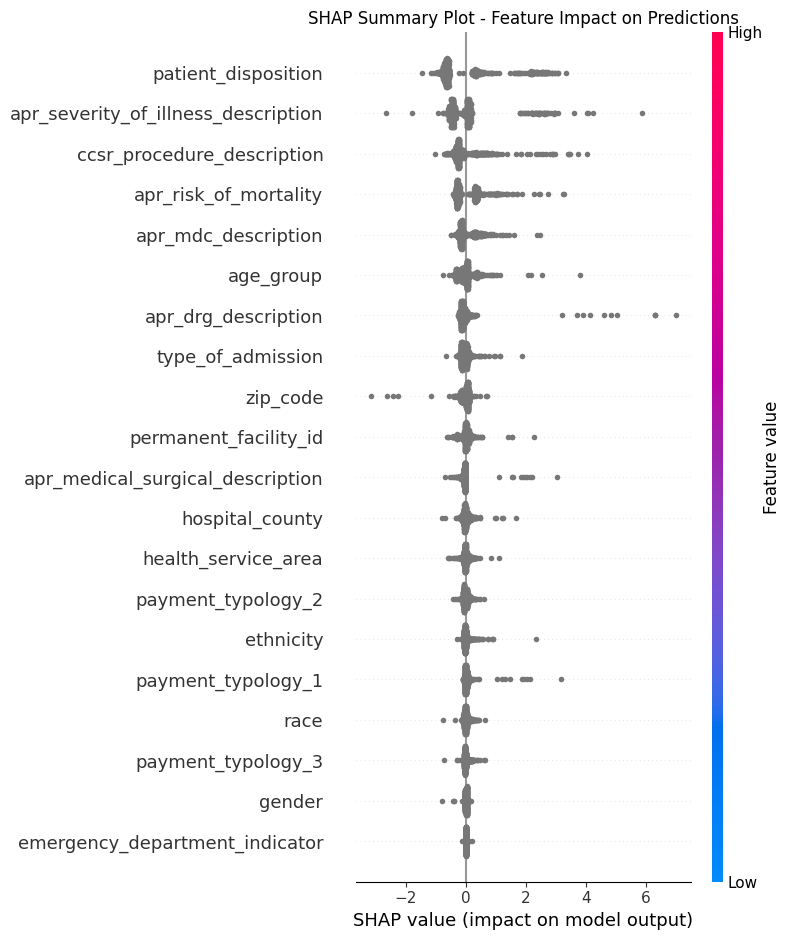

In [10]:
# shap analysis

# create SHAP explainer for CatBoost
explainer = shap.TreeExplainer(final_cat)

# calculate SHAP values on validation set
shap_values = explainer.shap_values(X_val_orig)

# detailed summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val_orig, show=False)
plt.title("SHAP Summary Plot - Feature Impact on Predictions")
plt.tight_layout()
plt.show()
plt.close()

In [11]:
shap_importance = pd.DataFrame({
    'feature': X_val_orig.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis = 0)
}).sort_values('mean_abs_shap', ascending = False)

print("Feature importance (mean absolute SHAP values)")
print(shap_importance.to_string(index = False))

Feature importance (mean absolute SHAP values)
                            feature  mean_abs_shap
                patient_disposition       0.865809
apr_severity_of_illness_description       0.466788
         ccsr_procedure_description       0.382120
              apr_risk_of_mortality       0.374350
                apr_mdc_description       0.254478
                          age_group       0.187704
                apr_drg_description       0.184684
                  type_of_admission       0.108896
                           zip_code       0.103471
              permanent_facility_id       0.099751
   apr_medical_surgical_description       0.088736
                    hospital_county       0.080861
                health_service_area       0.069858
                 payment_typology_2       0.069598
                          ethnicity       0.060016
                 payment_typology_1       0.055704
                               race       0.052156
                 payment_typology_3

These results are generally consistent with the OLS and random forest models.

In [12]:
catboost_model = {
    'catboost_model': final_cat,
    'category_mappings': category_mappings,
    'feature_names': X_train_orig.columns.tolist(),
    'hyperparameters': final_cat.get_all_params(),
    'model_type': 'catboost_native_categorical'
}

# save to file
with open('../models/catboost_model.pkl', 'wb') as f:
    pickle.dump(catboost_model, f)